# Statistics of the dataset

In [ ]:
import pandas as pd
import pyarrow.parquet as pq

In [27]:
#From now, we create our dataset from parquet data_lake

folder_data_lake = '../data_lake/btc_usd/'
table = pq.read_table(folder_data_lake)
df = table.to_pandas()
df = df.reset_index()

df.columns = [col[0] for col in df.columns]
print("Available columns:", df.columns.tolist())
print("Index_name :", df.index.name)


Available columns: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
Index_name : None


In [30]:
df.head()

,Date,Close,High,Low,Open,Volume
0,2016-01-01,434.334015,436.246002,427.515015,430.721008,36278900
1,2016-01-02,433.437988,436.062012,431.869995,434.622009,30096600
2,2016-01-03,430.010986,433.743011,424.705994,433.578003,39633800
3,2016-01-04,433.091003,434.516998,429.084015,430.061005,38477500
4,2016-01-05,431.959991,434.182007,429.675995,433.069000,34522600


In [29]:
df = df.drop_duplicates(subset=['Date'], keep='last')

In [31]:
df.describe()

,Date,Close,High,Low,Open,Volume
count,3651,3651.000000,3651.000000,3651.000000,3651.000000,3.651000e+03
mean,2020-12-30 00:00:00,30240.749593,30826.855590,29574.815755,30218.062784,2.440942e+10
min,2016-01-01 00:00:00,364.330994,374.950012,354.914001,365.072998,2.851400e+07
25%,2018-07-01 12:00:00,6413.792480,6534.830078,6314.354980,6412.694824,5.302091e+09
50%,2020-12-30 00:00:00,17128.724609,17513.900391,16794.458984,17112.933594,2.044390e+10
75%,2023-06-30 12:00:00,46418.066406,47404.132812,45141.027344,46375.728516,3.555472e+10
max,2025-12-29 00:00:00,124752.531250,126198.070312,123196.046875,124752.140625,3.509679e+11
std,NaN,32047.290983,32577.306452,31461.973737,32037.756382,2.288124e+10


In [32]:
print("Dataset Statistics:")
print(f"Number of records: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
print(f"Missing values:\n{df.isnull().sum()}")

Dataset Statistics:
Number of records: 3651
Columns: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
Missing values:
Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


In [33]:
print(df.head())

        Date       Close        High         Low        Open    Volume
0 2016-01-01  434.334015  436.246002  427.515015  430.721008  36278900
1 2016-01-02  433.437988  436.062012  431.869995  434.622009  30096600
2 2016-01-03  430.010986  433.743011  424.705994  433.578003  39633800
3 2016-01-04  433.091003  434.516998  429.084015  430.061005  38477500
4 2016-01-05  431.959991  434.182007  429.675995  433.069000  34522600


In [34]:
print(df.dtypes)

Date      datetime64[ns]
Close            float64
High             float64
Low              float64
Open             float64
Volume             int64
dtype: object


##XGBOOST

In [42]:
#Features creation for XGBOOST model

import pandas as pd
import numpy as np

def create_features_for_xgboost(df):
    # --- Step 0: Data Cleaning ---
    # Convert 'Date' to datetime objects and sort chronologically
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    
    # Clean 'Volume' (e.g., "10K" -> 10000) if it is a string
    if df['Volume'].dtype == object:
        df['Volume'] = df['Volume'].replace({'K': '*1e3', 'M': '*1e6', 'B': '*1e9'}, regex=True).map(pd.eval).astype(float)


    # --- Step 1: Feature Engineering ---
    
    # 1. Log Returns
    # We use log returns because they are time-additive and more stable than raw prices
    df['log_ret'] = np.log(df['Close'] / df['Close'].shift(1))
    
    # 2. Lag Features (Memory)
    # What happened yesterday? (Lag 1)
    df['ret_lag1'] = df['log_ret'].shift(1)
    # What happened one week ago? (Lag 7 - captures weekly cycles)
    df['ret_lag7'] = df['log_ret'].shift(7)
    # Volume from yesterday (Volume often precedes price movement)
    df['vol_lag1'] = df['Volume'].shift(1)
    
    # 3. Rolling Statistics (Trend & Volatility)
    # 30-day Moving Average (General monthly trend)
    df['ma_30'] = df['Close'].rolling(window=30).mean()
    
    # 30-day Standard Deviation (Is the market calm or chaotic?)
    df['std_30'] = df['log_ret'].rolling(window=30).std()
    
    # 4. Technical Indicators / Market Psychology
    # Distance from the Moving Average:
    # If positive/high -> Price is far above average (Potential bubble/overbought)
    # If negative/low -> Price is far below average (Potential oversold)
    df['dist_ma30'] = (df['Close'] / df['ma_30']) - 1
    
    # Daily Range: Normalized difference between High and Low
    # Shows intraday panic or euphoria
    df['daily_range'] = (df['High'] - df['Low']) / df['Close']
    # 5. Time Features
    # Crypto markets behave differently on weekends (Banks are closed)
    # 0 = Monday, 6 = Sunday
    df['day_of_week'] = df.index.dayofweek
    
    # --- Step 2: The Target ---
    # We want to predict the Price 7 days into the future.
    # On calcule la variation entre le prix dans 7 jours et le prix d'aujourd'hui
    df['target'] = np.log(df['Close'].shift(-7) / df['Close'])

    # Remove empty rows (NaNs) created by shifting and rolling
    df = df.dropna()
    
    return df

In [43]:
#Convert to float
df['Close'] = df['Close'].astype(str).str.replace(',', '').str.replace('$', '')
df['Close'] = df['Close'].astype(float)

df['High'] = df['High'].astype(str).str.replace(',', '').str.replace('$', '')
df['High'] = df['High'].astype(float)

df['Low'] = df['Low'].astype(str).str.replace(',', '').str.replace('$', '')
df['Low'] = df['Low'].astype(float)

df['Open'] = df['Open'].astype(str).str.replace(',', '').str.replace('$', '')
df['Open'] = df['Open'].astype(float)

df = create_features_for_xgboost(df)

In [44]:
df.head()

,Close,High,Low,Open,Volume,log_ret,ret_lag1,ret_lag7,vol_lag1,ma_30,std_30,dist_ma30,daily_range,day_of_week,target
Date,,,,,,,,,,,,,,,
2016-01-31,368.766998,380.346985,367.834991,378.292999,37894300,-0.025404,-0.003217,0.039172,30284400.0,410.061501,0.044373,-0.100703,0.033929,6,0.021072
2016-02-01,373.056000,378.071991,367.957001,369.350006,51656700,0.011564,-0.025404,-0.028302,37894300.0,408.048768,0.044478,-0.085756,0.027114,0,0.001048
2016-02-02,374.447998,375.882996,372.920013,372.920013,40378700,0.003724,0.011564,0.001089,51656700.0,406.196668,0.044503,-0.078161,0.007913,1,0.004213
2016-02-03,369.949005,374.950012,368.045013,374.645996,45933400,-0.012088,0.003724,0.007163,40378700.0,404.091935,0.044466,-0.084493,0.018665,2,0.031136
2016-02-04,389.593994,391.608002,369.993011,370.174011,69285504,0.051740,-0.012088,-0.037883,45933400.0,402.679735,0.045668,-0.032497,0.055481,3,-0.025845


In [45]:
features_to_drop = ['target', 'Open', 'High', 'Low'] # On garde Price pour référence si besoin, sinon on l'enlève
X = df.drop(columns=features_to_drop)

# y = Ce qu'on veut prédire
y = df['target']

In [46]:
X.head()

,Close,Volume,log_ret,ret_lag1,ret_lag7,vol_lag1,ma_30,std_30,dist_ma30,daily_range,day_of_week
Date,,,,,,,,,,,
2016-01-31,368.766998,37894300,-0.025404,-0.003217,0.039172,30284400.0,410.061501,0.044373,-0.100703,0.033929,6
2016-02-01,373.056000,51656700,0.011564,-0.025404,-0.028302,37894300.0,408.048768,0.044478,-0.085756,0.027114,0
2016-02-02,374.447998,40378700,0.003724,0.011564,0.001089,51656700.0,406.196668,0.044503,-0.078161,0.007913,1
2016-02-03,369.949005,45933400,-0.012088,0.003724,0.007163,40378700.0,404.091935,0.044466,-0.084493,0.018665,2
2016-02-04,389.593994,69285504,0.051740,-0.012088,-0.037883,45933400.0,402.679735,0.045668,-0.032497,0.055481,3


In [47]:
print(y)

Date
2016-01-31    0.021072
2016-02-01    0.001048
2016-02-02    0.004213
2016-02-03    0.031136
2016-02-04   -0.025845
                ...   
2025-12-18    0.020525
2025-12-19   -0.009144
2025-12-20   -0.006152
2025-12-21   -0.008908
2025-12-22   -0.011155
Name: target, Length: 3614, dtype: float64


In [48]:
# --- Step 1: Split Data for Training vs. Inference ---

# Check shape before dropping
print(f"Original shape: {df.shape}")

# A. Create the Training Set
# We remove rows where 'target' is NaN (the last 7 days) because we can't learn from them.
df_train = df.dropna(subset=['target'])
X_train = df_train.drop(columns=['target'])
y_train = df_train['target']

# B. Create the Prediction Input (The "Live" Data)
# We want the very last row (today) to predict next week.
# This row HAS features (X) but NO target (y is NaN), which is normal.
X_latest = df.drop(columns=['target']).tail(1)

print(f"Training shape: {X_train.shape}")
print(f"Prediction input shape: {X_latest.shape}")

# --- Step 2: Train the Model ---
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)

# --- Step 3: Predict the Future ---
# We use the latest available data (X_latest) to forecast
prediction_log_ret = model.predict(X_latest)

# Convert log return back to percentage for human readability
predicted_return_pct = (np.exp(prediction_log_ret) - 1) * 100

print(f"Predicted return for the next 7 days: {predicted_return_pct[0]:.2f}%")

Original shape: (3614, 15)
Training shape: (3614, 14)
Prediction input shape: (1, 14)
Predicted return for the next 7 days: -0.65%


Training data: 2891 days
Testing data: 723 days

--- Performance Report ---
Mean Absolute Error (MAE): 10.63%
Root Mean Squared Error (RMSE): 12.45%


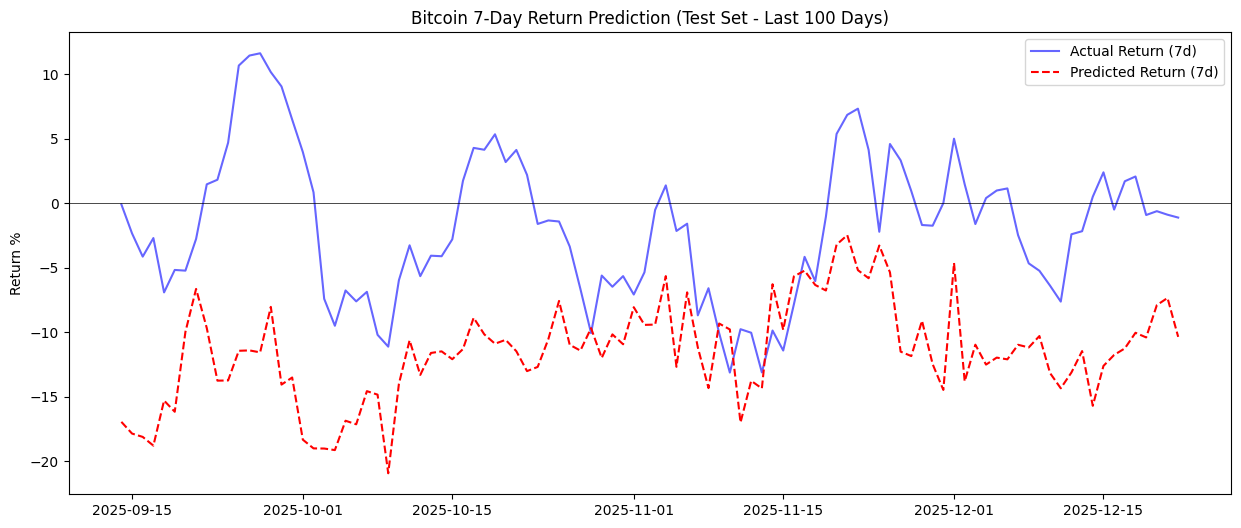

In [49]:
#Performance of the model

import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Supposons que tu as déjà ton X et y propres
# X = tes features
# y = ton target (log return à 7 jours)

# --- Step 1: Time Series Split ---
# We generally take the first 80% of time for training, and the last 20% for testing.
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

# Crucial: We split by index order, NOT randomly
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"Training data: {len(X_train)} days")
print(f"Testing data: {len(X_test)} days")

# --- Step 2: Training ---
model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=100, 
    learning_rate=0.1,
    max_depth=5
)

model.fit(
    X_train, 
    y_train,
    # Optional: We can use the test set as eval_set to stop early if it overfits
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# --- Step 3: Evaluation ---
# We ask the model to predict on the Test set (data it has never seen during training)
preds_log = model.predict(X_test)

# Convert log returns back to percentage for human interpretation
# Formula: (exp(log_return) - 1) * 100
preds_pct = (np.exp(preds_log) - 1) * 100
actual_pct = (np.exp(y_test) - 1) * 100

# Calculate Error Metrics
mae = mean_absolute_error(actual_pct, preds_pct)
rmse = np.sqrt(mean_squared_error(actual_pct, preds_pct))

print(f"\n--- Performance Report ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}%")
# Interpretation: On average, the model is off by {mae}% regarding the weekly return.

# --- Step 4: Visualization ---
plt.figure(figsize=(15, 6))

# Plotting the last 100 days of the test set for clarity
# (Plotting everything can be messy)
limit = 100 

plt.plot(y_test.index[-limit:], actual_pct[-limit:], label='Actual Return (7d)', color='blue', alpha=0.6)
plt.plot(y_test.index[-limit:], preds_pct[-limit:], label='Predicted Return (7d)', color='red', linestyle='--')

plt.title(f"Bitcoin 7-Day Return Prediction (Test Set - Last {limit} Days)")
plt.ylabel("Return %")
plt.axhline(0, color='black', linewidth=0.5) # Zero line
plt.legend()
plt.show()